# VAEP 모델 비교: CatBoost vs XGBoost

이 노트북에서는 K-League 데이터를 사용하여 VAEP 점수를 계산하기 위한 두 가지 강력한 부스팅 모델인 CatBoost와 XGBoost의 성능을 비교합니다.

## 1. 환경 설정 및 데이터 로드

In [1]:
import pandas as pd
import yaml
import os
import glob
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels

# 설정 로드
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

SPADL_DIR = os.path.join('..', config['data']['spadl_output_dir'])
NB_PREV_ACTIONS = config['features']['nb_prev_actions']

def load_spadl_data():
    all_games = []
    files = glob.glob(os.path.join(SPADL_DIR, "game_*.csv"))
    print(f"Loading {len(files)} games for model comparison...")
    for f in files:
        df = pd.read_csv(f)
        all_games.append(df)
    return all_games

games = load_spadl_data()

Loading 198 games for model comparison...


## 2. Feature 및 Label 생성

In [2]:
def get_feature_functions():
    return [
        features.actiontype_onehot,
        features.result_onehot,
        features.actiontype_result_onehot,
        features.bodypart_onehot,
        features.time,
        features.startlocation,
        features.endlocation,
        features.movement,
        features.space_delta,
        features.team,
    ]

def generate_dataset(games):
    X_list = []
    Y_list = []
    xfns = get_feature_functions()

    print("Generating features and labels...")
    for game in games:
        try:
            gamestates = features.gamestates(game, NB_PREV_ACTIONS)
            X_game = pd.concat([fn(gamestates) for fn in xfns], axis=1)
            
            Y_scores = labels.scores(game, nr_actions=10)
            Y_concedes = labels.concedes(game, nr_actions=10)
            Y_game = pd.concat([Y_scores, Y_concedes], axis=1)
            Y_game.columns = ['scores', 'concedes']
            
            X_list.append(X_game)
            Y_list.append(Y_game)
        except Exception as e:
            print(f"Skipping game due to error: {e}")
            continue

    if not X_list:
        raise ValueError("No data generated.")

    X = pd.concat(X_list).reset_index(drop=True)
    Y = pd.concat(Y_list).reset_index(drop=True)
    return X, Y

X, Y = generate_dataset(games)
print(f"Dataset shape: {X.shape}")

Generating features and labels...


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\socceraction\vaep\features.py:93: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prev_actions = actions.groupby(["game_id", "period_id"], sort=False, as_index=False).apply(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\socceraction\vaep\features.py:93: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prev_actions = actions.g

Dataset shape: (504242, 551)


## 3. 모델 학습 및 평가

데이터를 학습 세트와 검증 세트로 나누고(80:20), 각 모델을 학습시킵니다.
- **CatBoost**: 범주형 변수 처리에 강점이 있으며 기본 설정으로도 좋은 성능을 보입니다.
- **XGBoost**: 빠르고 효율적이며 튜닝 시 높은 성능을 낼 수 있습니다.

In [3]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

models = {
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    # Scoring Model
    model.fit(X_train, Y_train['scores'])
    pred_scores = model.predict_proba(X_val)[:, 1]
    auc_scores = roc_auc_score(Y_val['scores'], pred_scores)
    
    # Conceding Model
    model.fit(X_train, Y_train['concedes'])
    pred_concedes = model.predict_proba(X_val)[:, 1]
    auc_concedes = roc_auc_score(Y_val['concedes'], pred_concedes)
    
    results[name] = {
        'AUC (Scores)': auc_scores,
        'AUC (Concedes)': auc_concedes,
        'Average AUC': (auc_scores + auc_concedes) / 2,
        'pred_scores': pred_scores,
        'pred_concedes': pred_concedes
    }
    print(f"{name} Results: {results[name]}")

Training CatBoost...
CatBoost Results: {'AUC (Scores)': 0.8262959214168697, 'AUC (Concedes)': 0.8194611934736111, 'Average AUC': 0.8228785574452404, 'pred_scores': array([2.24247060e-03, 2.75162759e-04, 2.86687168e-03, ...,
       2.22390711e-03, 1.80929056e-03, 9.55059038e-05]), 'pred_concedes': array([0.00048695, 0.00133969, 0.00062623, ..., 0.00038879, 0.00041555,
       0.00019727])}
Training XGBoost...


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:18:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:18:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results: {'AUC (Scores)': 0.8491456759599995, 'AUC (Concedes)': 0.8119912438376014, 'Average AUC': 0.8305684598988003, 'pred_scores': array([0.00403018, 0.00015116, 0.00274314, ..., 0.00080372, 0.00088598,
       0.00110194], dtype=float32), 'pred_concedes': array([1.3834970e-04, 1.5383756e-03, 5.5217440e-04, ..., 2.5583731e-05,
       3.2164201e-03, 2.1097267e-05], dtype=float32)}


## 4. 결과 시각화 (ROC Curve)

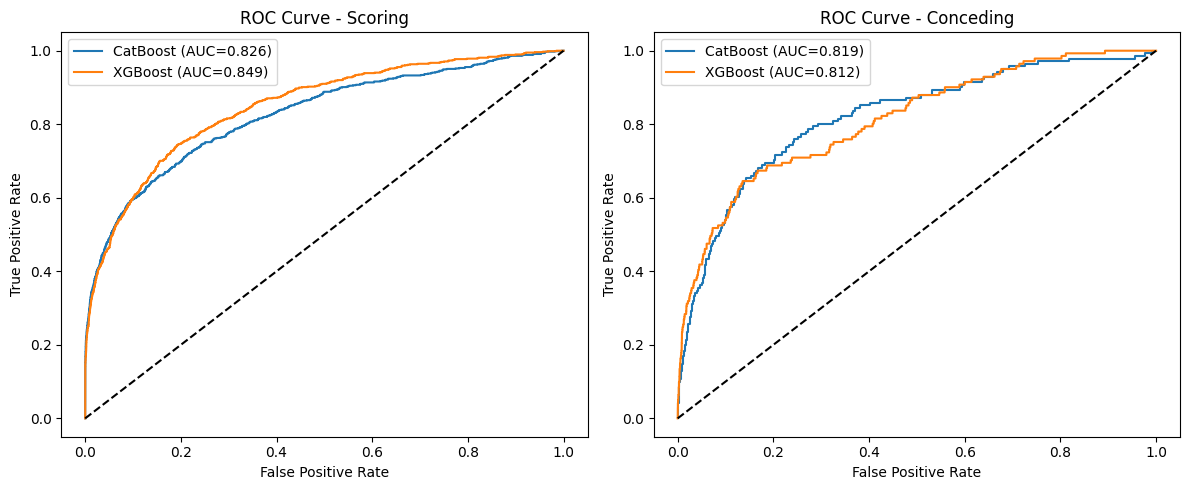

In [4]:
plt.figure(figsize=(12, 5))

# Scoring ROC
plt.subplot(1, 2, 1)
for name in models.keys():
    fpr, tpr, _ = roc_curve(Y_val['scores'], results[name]['pred_scores'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={results[name]['AUC (Scores)']:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Scoring')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Conceding ROC
plt.subplot(1, 2, 2)
for name in models.keys():
    fpr, tpr, _ = roc_curve(Y_val['concedes'], results[name]['pred_concedes'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={results[name]['AUC (Concedes)']:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Conceding')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.tight_layout()
plt.savefig('../results/model_comparison_roc.png')
plt.show()

## 5. 결론

위의 ROC 커브와 AUC 점수를 통해 어떤 모델이 K-League 데이터셋에 더 적합한지 판단할 수 있습니다. 일반적으로 두 모델 모두 우수한 성능을 보이지만, 데이터 특성에 따라 미세한 차이가 발생할 수 있습니다.